Download all the relevant packages

In [1]:
pip install pandas matplotlib tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mittens

Note: you may need to restart the kernel to use updated packages.


Import GloVE

In [6]:
from mittens import GloVe

2025-11-16 06:11:02.621078: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
import pandas as pd

Load the Newsroom training data

In [11]:
train = pd.read_json(
    "../Data/newsroom_test.jsonl",
    lines=True,
    dtype={'text': 'string', 'date': 'string'}
)

# required columns
train = train[["date", "text"]].dropna()

# year
train["year"] = pd.to_datetime(train["date"], errors="coerce").dt.year

# year range
train = train[(train.year >= 1998) & (train.year <= 2016)]

# final columns
train = train[["year", "text"]]

train.head()

,year,text


In [13]:
print("Initially loaded:", len(train))

Initially loaded: 0


In [15]:
import os
path = "../Data/newsroom_test.jsonl"

print("Exists:", os.path.exists(path))
print("Size (bytes):", os.path.getsize(path) if os.path.exists(path) else None)

Exists: True
Size (bytes): 4756379171


In [17]:
with open("../Data/newsroom_test.jsonl", "r") as f:
    for _ in range(5):
        print(f.readline())

{"url":"http:\/\/www.nytimes.com\/2006\/06\/04\/sports\/soccer\/04racism.html","archive":"http:\/\/web.archive.org\/web\/20060618204254id_\/http:\/\/www.nytimes.com:80\/2006\/06\/04\/sports\/soccer\/04racism.html?ei=5090&en=2cc7885a61bb8cf5&ex=1307073600&partner=rssuserland&emc=rss&pagewanted=all","title":"Surge in Racist Mood Raises Concerns on Eve of World Cup","date":"20060618204254","text":"HAMBURG, Germany, June 3 \u0097 As he left the soccer field after a club match in the eastern German city of Halle on March 25, the Nigerian forward Adebowale Ogungbure was spit upon, jeered with racial remarks and mocked with monkey noises. In rebuke, he placed two fingers under his nose to simulate a Hitler mustache and thrust his arm in a Nazi salute.\n\nMarc Zoro, right, an Ivory Coast native, was a target of racial slurs from the home fans in Messina, Italy. Adriano, a star with Inter Milan, tried to persuade him to stay on the field.\n\nFrom now until its conclusion on July 9, Jeff Z. Klei

In [19]:
records = []
path = "../Data/newsroom_test.jsonl"   

with open(path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        try:
            obj = json.loads(line)
            records.append(obj)
        except:
            continue

train = pd.DataFrame(records)
print("Loaded rows:", len(train))
train.head()

Loaded rows: 995041


,url,archive,title,date,text,summary,compression,coverage,density,compression_bin,coverage_bin,density_bin
0,http://www.nytimes.com/2006/06/04/sports/socce...,http://web.archive.org/web/20060618204254id_/h...,Surge in Racist Mood Raises Concerns on Eve of...,20060618204254,"HAMBURG, Germany, June 3  As he left the socc...",A surge in discriminatory behavior toward blac...,137.470588,1.000000,7.823529,high,high,mixed
1,http://www.nytimes.com/2005/12/24/politics/24s...,http://web.archive.org/web/20060620043011id_/h...,"Spy Agency Mined Vast Data Trove, Officials Re...",20060620043011,"WASHINGTON, Dec. 23 - The National Security Ag...","The volume of information harvested, without \...",33.636364,0.909091,4.727273,medium,medium,mixed
2,http://www.nytimes.com/2006/04/23/business/you...,http://web.archive.org/web/20060909062911id_/h...,Investors vs. Pfizer: Guess Who Has the Guns?,20060909062911,IF outsized executive pay has indeed become a ...,The battle between Pfizer Inc.'s investors and...,33.880000,1.000000,11.720000,medium,high,extractive
3,http://www.nydailynews.com/archives/gossip/199...,http://web.archive.org/web/20080313232743id_/h...,REX FLEXED PECS FOR SKIN PICS,20080313232743,BY A.J. BENZA & MICHAEL LEWITTES\n\nIf Simon R...,"If Simon Rex looks a little familiar, it may n...",11.894118,0.988235,38.988235,low,high,extractive
4,http://www.nydailynews.com/archives/entertainm...,http://web.archive.org/web/20080314003027id_/h...,POPEYE-WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...,20080314003027,Spinach has terrorized generations of veggie-p...,POPEYE-WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...,3.932584,0.921348,36.629213,low,medium,extractive


In [21]:
train["year"] = train["date"].astype(str).str[:4].astype(int)

Filter to the years used in the paper

In [24]:
train = train[(train.year >= 1998) & (train.year <= 2016)]

Keep only the year and text features

In [27]:
train = train[["year", "text"]]

Save as parquet file for computational ease

In [30]:
train.to_parquet("newsroom_train_small.parquet", compression="snappy")

In [32]:
df = pd.read_parquet("newsroom_train_small.parquet")

Specify the embedding year window (3-year windows)

In [35]:
window_years = list(range(1999, 2016))
window_years

[1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015]

In [37]:
windows = {}

for year in window_years:
    window_df = df[(df["year"] >= year - 1) & (df["year"] <= year + 1)]
    all_text = " ".join(window_df["text"].astype(str).tolist())
    windows[year] = all_text
    print(year, "→", len(window_df), "articles")

1999 → 153 articles
2000 → 701 articles
2001 → 798 articles
2002 → 705 articles
2003 → 305 articles
2004 → 1991 articles
2005 → 9479 articles
2006 → 20325 articles
2007 → 41102 articles
2008 → 64366 articles
2009 → 119142 articles
2010 → 183196 articles
2011 → 261230 articles
2012 → 299762 articles
2013 → 351475 articles
2014 → 431909 articles
2015 → 554792 articles


**NOTE**: Newsroom seems heavily skweed towards recent years. 

First, perform some **preprocessing**

In [41]:
import re

stopwords = set([
    "the","a","and","of","in","to","for","on","at","by","with","from","that",
    "this","it","is","as","an","be","are","was","were"
])

def tokenize(text):
    text = text.lower()
    tokens = re.findall(r"[a-z]+", text)
    return [t for t in tokens if t not in stopwords and len(t) > 2]

Build vocabulary

In [44]:
from collections import Counter

def build_vocab(text, vocab_size=6000):
    tokens = tokenize(text)
    freq = Counter(tokens)
    vocab = [w for w, c in freq.most_common(vocab_size)]
    return vocab, tokens

Build co-occurrence matrix

In [47]:
import numpy as np
from collections import defaultdict

def build_cooc(tokens, vocab, window_size=4):
    vocab_index = {w: i for i, w in enumerate(vocab)}
    cooc = defaultdict(float)

    for i, word in enumerate(tokens):
        if word not in vocab_index:
            continue
        w_i = vocab_index[word]

        start = max(0, i - window_size)
        end = min(len(tokens), i + window_size + 1)

        for j in range(start, end):
            if i == j:
                continue
            other = tokens[j]
            if other in vocab_index:
                w_j = vocab_index[other]
                cooc[(w_i, w_j)] += 1.0

    return cooc, vocab_index

Train GloVE

In [50]:
from mittens import GloVe

def train_glove(cooc, vocab_size, embed_dim=50, max_iter=50):
    matrix = np.zeros((vocab_size, vocab_size))

    for (i, j), v in cooc.items():
        matrix[i, j] = v

    glove = GloVe(n=embed_dim, max_iter=max_iter)
    embeddings = glove.fit(matrix)

    return embeddings

The complete pipeline

In [ ]:
import pickle

year_embeddings = {}

for year in window_years:
    print(f"\nYEAR {year}")

    text = windows[year]

    # adjust vocab size 
    size = len(text.split())
    if size < 200_000:
        vocab_size = 3000
    elif size < 1_000_000:
        vocab_size = 6000
    else:
        vocab_size = 8000

    vocab, tokens = build_vocab(text, vocab_size=vocab_size)
    cooc, vocab_index = build_cooc(tokens, vocab)

    embeddings = train_glove(cooc, len(vocab), embed_dim=50, max_iter=40)

    year_embeddings[year] = {
        "embeddings": embeddings,
        "vocab": vocab,
        "vocab_index": vocab_index
    }

    with open(f"embeddings_{year}.pkl", "wb") as f:
        pickle.dump(year_embeddings[year], f)

    print(f"Saved embeddings for {year}")


--- YEAR 1999 ---
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2025-11-16 06:36:04.030890: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
Iteration 40: loss: 442.2826232910156

Saved embeddings for 1999

--- YEAR 2000 ---


/opt/anaconda3/lib/python3.12/site-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
Iteration 40: loss: 4823.81251953125

Saved embeddings for 2000

--- YEAR 2001 ---


Iteration 40: loss: 5870.14160156255

Saved embeddings for 2001

--- YEAR 2002 ---


Iteration 40: loss: 5545.64013671875

Saved embeddings for 2002

--- YEAR 2003 ---


Iteration 40: loss: 1921.7823486328125

Saved embeddings for 2003

--- YEAR 2004 ---


Iteration 40: loss: 30714.880859375

Saved embeddings for 2004

--- YEAR 2005 ---


Iteration 40: loss: 161291.453125

Saved embeddings for 2005

--- YEAR 2006 ---


Iteration 40: loss: 302675.21875

Saved embeddings for 2006

--- YEAR 2007 ---


Iteration 40: loss: 568986.2525

Saved embeddings for 2007

--- YEAR 2008 ---


Iteration 40: loss: 823940.3125

Saved embeddings for 2008

--- YEAR 2009 ---


Iteration 40: loss: 1303383.375

Saved embeddings for 2009

--- YEAR 2010 ---


Iteration 40: loss: 1682711.875

Saved embeddings for 2010

--- YEAR 2011 ---


Iteration 40: loss: 2093391.55

Saved embeddings for 2011

--- YEAR 2012 ---


Iteration 40: loss: 2249532.05

**NOTE** Had to abort at year 2012 because the system kept on crashing again and again.

Import other relevant packages

In [3]:
import os
import glob
import numpy as np
import random
import matplotlib.pyplot as plt

Specify the pathway for the embeddings files and load them

Build 3-year rolling windows for the embeddings

In [23]:
path = "../Newsroom_Embeddings/embeddings_1999.pkl"  

with open(path, "rb") as f:
    sample = pickle.load(f)

# Print sample keys and first 5 values
print("Type:", type(sample))
print("Number of keys:", len(sample))

some_key = list(sample.keys())[0]
print("Sample key:", some_key)
print("Sample value:", sample[some_key])

Type: <class 'dict'>
Number of keys: 3
Sample key: embeddings
Sample value: [[ 6.5586686e-01 -6.5846527e-01 -4.4021189e-01 ... -6.6140890e-01
  -6.7355812e-01  5.7970113e-01]
 [ 4.4009590e-01 -4.9411052e-01 -6.2440419e-01 ... -4.1560954e-01
  -6.0623085e-01  5.5167031e-01]
 [ 5.2465743e-01 -8.8144112e-01 -7.5497377e-01 ... -3.3428222e-01
  -5.3876579e-01  6.7794847e-01]
 ...
 [-4.7266353e-03  1.5272332e-02  2.6329584e-02 ...  4.8194956e-03
   6.6294149e-04 -3.3637017e-02]
 [-9.1072537e-02 -1.8477138e-02  1.3486221e-02 ... -6.5841153e-04
  -5.1950332e-02 -4.9956404e-03]
 [-6.7061923e-02  1.9032581e-02 -1.3824772e-02 ...  1.6856110e-02
  -2.0228082e-02  1.5320977e-02]]


In [25]:
path = "../Newsroom_Embeddings/embeddings_1999.pkl"   # ← relative path

with open(path, "rb") as f:
    data = pickle.load(f)

print("Keys in file:", list(data.keys()))

Keys in file: ['embeddings', 'vocab', 'vocab_index']


In [27]:
EMB_PATH = "../Newsroom_Embeddings"

# Load embeddings
embedding_files = glob.glob(os.path.join(EMB_PATH, "embeddings_*.pkl"))

year_embeddings = {}

for path in embedding_files:
    with open(path, "rb") as f:
        data = pickle.load(f)

    # Extract year
    year = int(os.path.basename(path).replace("embeddings_", "").replace(".pkl", ""))

    # Extract components
    vectors = np.array(data["embeddings"])   
    vocab   = data["vocab"]                 
    w2i     = data["vocab_index"]           

    # Map word to vector
    emb = {word: vectors[idx] for word, idx in w2i.items()}

    year_embeddings[year] = emb

print("Loaded yearly embeddings for:", sorted(year_embeddings.keys()))

Loaded yearly embeddings for: [1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]


In [29]:
test_year = sorted(year_embeddings.keys())[0]
print("Example year:", test_year)

sample_word = list(year_embeddings[test_year].keys())[0]
print("Sample word:", sample_word)
print("Vector shape:", year_embeddings[test_year][sample_word].shape)

Example year: 1999
Sample word: said
Vector shape: (50,)


In [31]:
window_embeddings = {}

valid_years = []

for y in sorted(year_embeddings.keys()):
    if (y - 1 in year_embeddings) and (y + 1 in year_embeddings):
        valid_years.append(y)

print("Valid 3-year windows:", valid_years)

for y in valid_years:
    e_prev = year_embeddings[y - 1]
    e_curr = year_embeddings[y]
    e_next = year_embeddings[y + 1]

    vocab = set(e_prev.keys()) & set(e_curr.keys()) & set(e_next.keys())

    merged = {}
    for w in vocab:
        v1 = e_prev[w]
        v2 = e_curr[w]
        v3 = e_next[w]
        merged[w] = (v1 + v2 + v3) / 3.0

    window_embeddings[y] = merged

print("Done")

Valid 3-year windows: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]
Done


Specify the word lists required for the figure

In [34]:
islam_words = [
    "allah","ramadan","turban","emir","salaam","sunni","koran","imam","sultan",
    "prophet","veil","ayatollah","shiite","mosque","islam","sheik",
    "muslim","muhammad"
]

christ_words = [
    "baptism","messiah","catholicism","resurrection","christianity","salvation",
    "protestant","gospel","trinity","jesus","christ","christian","cross",
    "catholic","church"
]

terror_words = ["terror","terrorist","terrorism","jihad","attack","bomb","violence"]

Specify helpers

In [37]:
def cos(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v) + 1e-9)

def avg_vector(words, emb):
    vecs = [emb[w] for w in words if w in emb]
    if not vecs:
        return None
    return np.mean(vecs, axis=0)

Compute embedding bias as done in the paper

In [40]:
bias_scores = {}

for year, emb in window_embeddings.items():
    islam_vec = avg_vector(islam_words, emb)
    christ_vec = avg_vector(christ_words, emb)
    terror_vec = avg_vector(terror_words, emb)

    if islam_vec is None or christ_vec is None or terror_vec is None:
        continue

    score = cos(islam_vec - christ_vec, terror_vec)
    bias_scores[year] = score

print("Bias scores yearly:")
for y in sorted(bias_scores):
    print(y, round(bias_scores[y], 4))

Bias scores yearly:
2001 0.4104
2002 0.5868
2003 0.3996
2004 0.3999
2005 0.6484
2006 0.2741
2007 0.2367
2008 0.1859
2009 0.0228
2010 -0.4812
2011 -0.5092


Compute bootstrap standard errors

In [45]:
def bootstrap_se(emb, B=200):
    scores = []
    for _ in range(B):
        # Resample full lists with replacement
        iw = random.choices(islam_words, k=len(islam_words))
        cw = random.choices(christ_words, k=len(christ_words))

        iv = avg_vector(iw, emb)
        cv = avg_vector(cw, emb)
        tv = avg_vector(terror_words, emb)

        if iv is None or cv is None or tv is None:
            continue

        score = cos(iv - cv, tv)
        scores.append(score)

    return np.std(scores)

# standard errors
se = {}
print("Computing SE")
for y in bias_scores:
    se[y] = bootstrap_se(window_embeddings[y], B=200)
    print(f"Year {y}: SE = {se[y]:.4f}")

Computing SE
Year 2001: SE = 0.1677
Year 2002: SE = 0.2063
Year 2003: SE = 0.0950
Year 2004: SE = 0.0866
Year 2005: SE = 0.0812
Year 2006: SE = 0.1476
Year 2007: SE = 0.1499
Year 2008: SE = 0.1379
Year 2009: SE = 0.1937
Year 2010: SE = 0.2511
Year 2011: SE = 0.2166


Develop plot

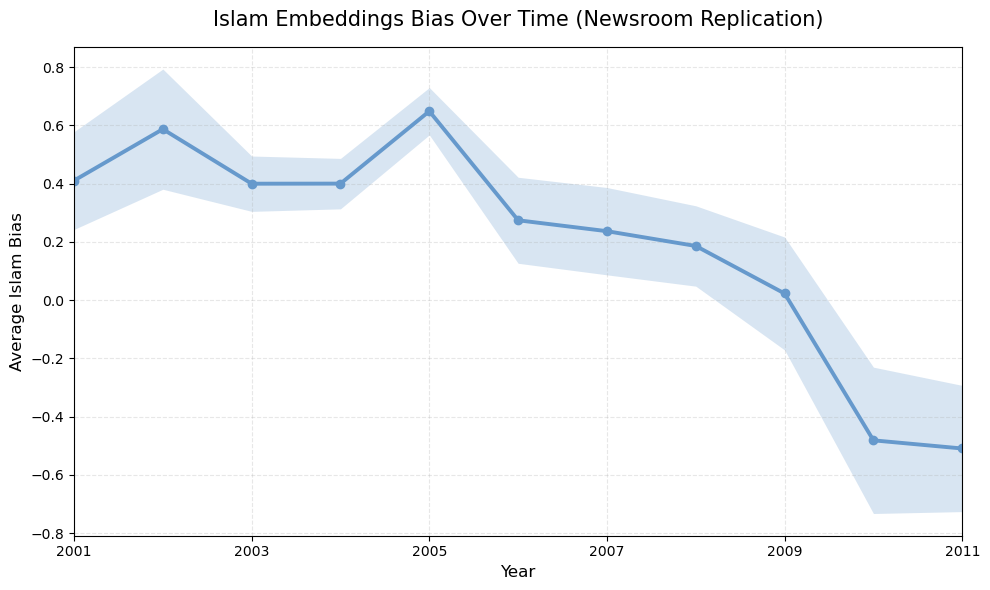

In [62]:
years = sorted(bias_scores.keys())
scores = np.array([bias_scores[y] for y in years])
ses = np.array([se[y] for y in years])

science_blue = "#6699CC"

fig, ax = plt.subplots(figsize=(10, 6))

# Bias line
ax.plot(
    years, scores,
    marker="o",
    markersize=6,
    linewidth=2.8,
    color=science_blue,
    label="Avg. Islam Bias"
)

# Standard error band
ax.fill_between(
    years,
    scores - ses,
    scores + ses,
    alpha=0.25,
    color=science_blue,
    linewidth=0
)

ax.set_title(
    "Islam Embeddings Bias Over Time (Newsroom Replication)",
    fontsize=15,
    pad=15
)

ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Average Islam Bias", fontsize=12)

ax.grid(alpha=0.3, linestyle="--")

tick_years = list(range(min(years), max(years) + 1, 2))
ax.set_xticks(tick_years)

ax.set_xlim(years[0], years[-1])
ax.set_xmargin(0)

plt.tight_layout()

plt.savefig(
    "../Figure/islam_bias_newsroom_replication.png",  
    dpi=600,
    bbox_inches="tight",
    facecolor="white"
)

plt.show()